In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

## Pasos
- Leer los datos
- Normalizar los datos
- implementar la función Sigmoidal $\sigma(x)=\frac{1}{1+\exp(-x)}$, y la función de hipótesis
- implementar la función de costo usando la función de entropía cruzada 
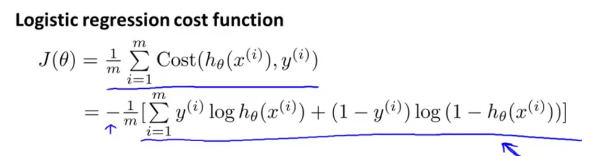
- calcular gradiente


# Leemos los datos

In [18]:
# leo los datos
Data = pd.read_csv('heart.csv')

Data = np.array(Data.iloc[:])
np.random.shuffle(Data)
print(Data)
X_input = np.array(Data[:,:13])
Y_input = np.array(Data[:,13])

print("X_train: ", X_input.shape)
print("Y_train: " , Y_input.shape)


[[66.  0.  0. ...  2.  3.  0.]
 [61.  0.  0. ...  0.  2.  0.]
 [52.  1.  0. ...  1.  2.  0.]
 ...
 [40.  1.  0. ...  0.  3.  0.]
 [43.  1.  0. ...  4.  3.  0.]
 [65.  1.  0. ...  1.  3.  0.]]
X_train:  (303, 13)
Y_train:  (303,)


# Normalizamos los datos

In [19]:
# esta función acepta un vector de dimensión 1, y y retorna una tupla
# con el vector normalizado, su media y su desviación estándar
def normalize(vector):
    media_vector = vector.mean(axis=0)
    std_vector = vector.std(axis=0)
    return (vector - media_vector) / std_vector, media_vector, std_vector

# esta función la utilizo para desnormalizar un vector normalizado, esto es con el objetivo
# de ver mis datos realísticmente, recibo la media y la desviación estándar para la desnormalización
def denormalize(vector, mean, std):
    vector *= std
    vector += mean

In [20]:
# normalizo los datos
n_el_input = X_input.shape[0]
X_train, X_media, X_std = normalize(X_input)
print(X_train)
X_train = np.concatenate((np.ones([n_el_input, 1]), X_train), axis=1)
X_train.shape

[[ 1.28306308 -1.46841752 -0.93851463 ... -0.64911323  1.24459328
   1.12302895]
 [ 0.73161895 -1.46841752 -0.93851463 ...  0.97635214 -0.71442887
  -0.51292188]
 [-0.26098049  0.68100522 -0.93851463 ...  0.97635214  0.26508221
  -0.51292188]
 ...
 [-1.58444641  0.68100522 -0.93851463 ...  0.97635214 -0.71442887
   1.12302895]
 [-1.25357993  0.68100522 -0.93851463 ... -0.64911323  3.20361543
   1.12302895]
 [ 1.17277425  0.68100522 -0.93851463 ... -0.64911323  0.26508221
   1.12302895]]


(303, 14)

# Función sigmoidal, complementando la función de hipótesis
- función sigmoidal  
$$
\sigma(x) = \frac{1}{1+\exp(-x)}
$$
- función de hipótesis
$$
\sigma(\theta^{T}x) = \frac{1}{1+\exp(-\theta^{T}x)}
$$


In [21]:
# implemento la función sigmoidal
def sigmoidal(x):
    return 1.0 / (1 + math.exp(-x)) 

# implemento la función de hipótesis
def H_theta(x, theta):
    return sigmoidal(x.dot(theta))

In [22]:
# pruebo mi función de H_theta con mis entradas
n_features_train = X_train.shape[1]
H_theta(X_train[0], np.zeros(n_features_train))


0.5

# Función de Costo (entropía cruzada)
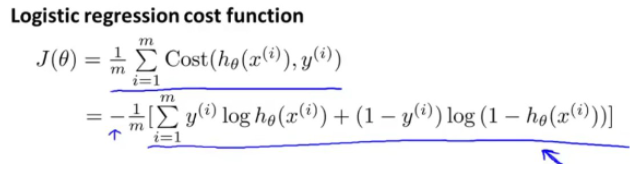

In [23]:
# implemento la función de costo, entropía cruzada
def Cost(X, Y, T):
    """
    X: inputs vector
    Y: output vector
    T: tetha vector
    """
    my_cost = 0;
    for i in range(X.shape[0]):
        my_cost += Y[i] * math.log(H_theta(X[i,:], T)) + (1 - Y[i]) * math.log(1 - H_theta(X[i,:], T))
    return (-1.0 / X.shape[0]) * my_cost

In [24]:
# probaré mi función de costo con un vector de puros ceros
Cost(X_train, Y_input, np.zeros(n_features_train))

0.6931471805599467

# Gradiente Descendiente
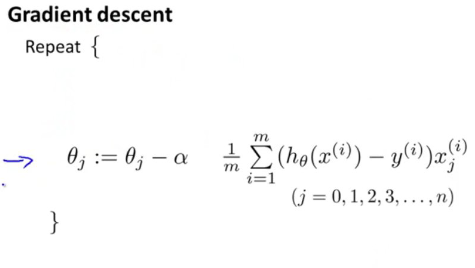

In [25]:
# implemento mi función calcular gradiente
def calcular_gradiente(X, Y, theta, alpha):
    sigma = np.vectorize(sigmoidal)
    Set_size = X.shape[0];
    M = sigma(X @ theta) - Y
    return theta - ((1/Set_size * alpha) * (M @ X))

In [26]:
# gradiente descendiente
def gradiente_Descendiente(X, Y, Tvec, it, alpha, costs):
    """
    X: el conjunto de entrenamiento
    Y: el vector de salidas
    tetha: el vector resultado
    it: el número de iteraciones
    alpha: tasa de aprendizaje
    """
    # Gradiente Descendiente Batch, esto solo lo calculo haciendo uso de operaciones matriciales
    
    Set_size = X.shape[0];
    for ite in range(it):
        #M = sigma(X @ Tvec) - Y
        #Tvec = Tvec - ((1/Set_size * alpha) * (M @ X))
        Tvec = calcular_gradiente(X, Y, Tvec, alpha)
        #calculating the cost and joining it to the list of cost
        costs.append(Cost(X, Y, Tvec))
    return Tvec

In [27]:
# una prueba inicial de mi algoritmo, con 50 iteraciones y tasa de aprendizaje 0.4
iterations =200
learning_rate = 0.4
costs = []
T = gradiente_Descendiente(X_train, Y_input, np.zeros(n_features_train), iterations, learning_rate, costs)
print("Resultado del regresor logístico: ", T)

Resultado del regresor logístico:  [ 0.11808693 -0.05008128 -0.81167959  0.8826191  -0.33700981 -0.23405314
  0.01291596  0.24471964  0.52219499 -0.46133894 -0.62575442  0.35585409
 -0.7867093  -0.5500018 ]


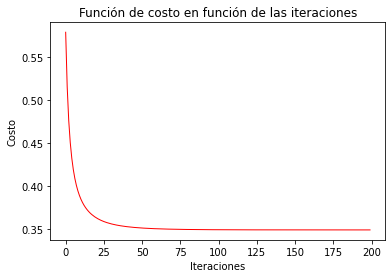

In [28]:
# graficamos la curva de costo, que claramente desciende
times = range(iterations)
plt.plot(times, costs, "r-", linewidth=1)
plt.title("Función de costo en función de las iteraciones")
plt.ylabel('Costo')
plt.xlabel("Iteraciones")
plt.show()

# Calculando el Accuracy de mi modelo

In [29]:
def calcular_accuracy(X, Y, theta):
    set_size = X.shape[0]
    correct = 0
    for idx in range(set_size):
        # si el valor de mi predicción es correcta, aumento en 1 mis resultados correctos
        if H_theta(X[idx,:], theta) >= 0.5 and Y[idx] == 1:
            correct += 1
    # retorno el accuracy
    return correct / set_size

In [30]:
# una prueba con el gradiente descendiente, con 50 iteraciones y tasa de aprendizaje 0.4
iterations =1000
learning_rate = 0.4
costs = []
T = gradiente_Descendiente(X_train, Y_input, np.zeros(n_features_train), iterations, learning_rate, costs)
# ahora calculamos el accuracy del predictor
calcular_accuracy(X_train, Y_input, T)


0.5016501650165016

# K-Fold Cross Validation

In [72]:
kf3 = KFold(n_splits=3, shuffle=True)

max_accuracy = 0;
max_group = 0;
g = 0;
for train_index, test_index in kf3.split(X_train):
    g += 1
    # Obtenemos los datos para calcular
    X_ktrain = np.array([X_train[i] for i in train_index])
    Y_ktrain = np.array([Y_input[i] for i in train_index])
    X_ktest = np.array([X_train[i] for i in test_index])
    Y_ktest = np.array([Y_input[i] for i in test_index])
    
    # Calculamos el accuracy para este kfold
    iterations =1000
    learning_rate = 0.4
    costs = []
    T = gradiente_Descendiente(X_ktrain, Y_ktrain, np.zeros(n_features_train), iterations, learning_rate, costs)
    accuracy = calcular_accuracy(X_ktest, Y_ktest, T)
    
    # Si obtenemos un accuracy mejor guardamos
    if accuracy > max_accuracy:
        max_group = g
        max_accuracy = accuracy
        
print("El mejor accuracy es %f del grupo %i" % (max_accuracy, max_group))    
    

El mejor accuracy es 0.534653 del grupo 1
